<a href="https://colab.research.google.com/github/kuba-cherryb/digit-classifier-PL/blob/main/digit_classifier_PL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><font size="4"><b>Technologia Mowy 2024</b></font></center>
<br />
<center><font size="6"><b><u>Projekt 1: Klasyfikator cyfr.</u></b></font></center>
<center>Jakub Czernecki, Wojciech Sabała, Bartosz Wąsik, 12/2024</center>

#Implementacja

##Import danych treningowych, grupowanie po etykietach

In [1]:
import os
import collections
import librosa
import numpy as np
import matplotlib.pyplot as plt
import sklearn.mixture as mx
import sklearn.model_selection as ms
import sklearn.preprocessing as pp
import re
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import train_test_split
from matplotlib import rcParams
import warnings

!git clone https://github.com/kuba-cherryb/digit-classifier-PL
%cd digit-classifier-PL
!unzip digits.zip
!unzip digit_classifier_test.zip
%cd train/

Cloning into 'digit-classifier-PL'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 6 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (6/6), 3.86 MiB | 9.63 MiB/s, done.
/content/digit-classifier-PL
Archive:  digits.zip
   creating: train/
  inflating: train/AO1M1_0_.wav      
  inflating: train/AO1M1_1_.wav      
  inflating: train/AO1M1_2_.wav      
  inflating: train/AO1M1_3_.wav      
  inflating: train/AO1M1_4_.wav      
  inflating: train/AO1M1_5_.wav      
  inflating: train/AO1M1_6_.wav      
  inflating: train/AO1M1_7_.wav      
  inflating: train/AO1M1_8_.wav      
  inflating: train/AO1M1_9_.wav      
  inflating: train/BC1M1_0_.wav      
  inflating: train/BC1M1_1_.wav      
  inflating: train/BC1M1_2_.wav      
  inflating: train/BC1M1_3_.wav      
  inflating: train/BC1M1_4_.wav      
  inflating: train/BC1M1_5_.wav      
  inflating: train/BC1M1_

In [2]:
all_files = sorted(os.listdir())

train = [[] for _ in range(10)]

for fname in all_files:
    res = re.findall("_(\d+)_.wav", fname)
    train[int(res[0])].append(fname)

##Parametryzacja - MFCC, delty (librosa) + CMVN


In [3]:
def cmvn(mfcc:list):
  stdevs = np.std(mfcc,axis=1)
  means = np.mean(mfcc,axis=1)
  return ((mfcc.T - means)/stdevs).transpose()

In [4]:
warnings.filterwarnings("ignore", category=UserWarning, module="librosa")
def generate_mfcc(data:list, n_mfcc:int=8):
  mfccs = []

  for i in range(len(data)):
    list_mfccs = []
    for fname in data[i]:
      A, fs = librosa.load(fname)
      MFCC_librosa_x = librosa.feature.mfcc(y=A,n_mfcc=n_mfcc,
                                            lifter=2*n_mfcc,
                                            win_length = 320,
                                            hop_length=160,
                                            n_fft=320)
      MFCC_librosa_x = cmvn(MFCC_librosa_x)
      mfcc_delta = librosa.feature.delta(MFCC_librosa_x) #delta
      mfcc_delta2 = librosa.feature.delta(MFCC_librosa_x, order=2) #delta^2

      MFCC_bundle = np.concatenate((MFCC_librosa_x, mfcc_delta, mfcc_delta2)) # po konkatenacji mfcc z deltami dostajemy na wyjściu jednak 2D zbiór sklejony pionowo
      list_mfccs.append(MFCC_bundle.T) # transponacja macierzy bardzo ważna

    mfccs.append(list_mfccs)
  return mfccs

##Tworzenie i tuning GMM

In [5]:
def train_gmm(mfcc:list, n:int=8, cov_type:str='diag'):
  gmms = []
  for i in range(len(mfcc)):
    gmm = mx.GaussianMixture(n_components=n,
                             covariance_type=cov_type)
    obs = np.concatenate(mfcc[i])
    gmm_fit = gmm.fit(obs)
    gmms.append(gmm_fit)
  return gmms

##Wzór Bayesa

In [6]:
def nb_score(gmm_models:list,sample_mfcc:list,verbose:bool=False):
  scores = []
  for i in range(len(gmm_models)):
    scores.append(np.exp(gmm_models[i].score(sample_mfcc)))

  total_probability = np.sum(scores)
  probabilities = scores / total_probability
  predicted_digit = np.argmax(probabilities)

  if verbose:
      digit_labels = range(10)  # Labels
      probability_dict = dict(zip(digit_labels, probabilities))

      # sortowanie prawdopodobieństw
      probability_dict = dict(sorted(probability_dict.items(), key=lambda item: item[1], reverse=True))

      plt.bar(probability_dict.keys(), probability_dict.values())
      plt.style.use("dark_background")
      plt.xticks(digit_labels)
      plt.xlabel("Digit")
      plt.ylabel("Probability")
      plt.show()

      print("\nCalculated Bayesian probabilities:\n", probability_dict)
      print("\nModel's prediction: ", predicted_digit)

  return predicted_digit, probabilities


##Ewaluacja modelu

In [7]:
#funkcja binarnej ewaluacji modelu
def check_train(train:list, gmms:list, verbose:bool=False):
  a = len(train[0])
  b = len(train)
  result = np.zeros((b, a), dtype=np.bool_)

  for i in range(b):
    for j in range(a):
      prediction, prob = nb_score(gmms, train[i][j])
      result[i][j] = (prediction == i)

  positive = np.count_nonzero(result)
  negative = np.count_nonzero(result == False)
  acc = round(positive/(a*b),2)

  #tak jak w przypadku nb_score() verbose ładnie wypisuje wyniki
  if verbose == True:
    print('Result:\n', result)
    print("\nAccuracy: ", acc)

  return result, acc


##K-fold Split


In [8]:
def generate_digit_subset(data: list, indices: list):
  subset = []
  for y in range(10):
      sublist = [data[y][x] for x in indices]
      subset.append(sublist)
  return subset

def banana_split(train: list, folds: int = 11, mix: bool = True, verbose=False):
  kfs = ms.KFold(n_splits=folds, shuffle=mix)
  kfs.get_n_splits(train[0])
  accs = []
  models = []

  for i, (train_index, test_index) in enumerate(kfs.split(train[0])):

      # używam funkcji zdefiniowanej powyżej, generującej podzbiory
      trains = generate_digit_subset(train, train_index)
      tests = generate_digit_subset(train, test_index)

      train_mfcc = generate_mfcc(trains)
      train_gmms = train_gmm(train_mfcc)
      models.append(train_gmms)

      test_mfcc = generate_mfcc(tests)
      result, acc = check_train(test_mfcc, train_gmms, verbose=False)

      if verbose:
        print(f"Fold {i+1}:\n Accuracy: {acc}\n")

      accs.append(acc)

  final_acc = round(np.mean(accs), 2)
  final_std = round(np.std(accs), 2)

  if verbose:
      print(f"Crossvalidated accuracy: {final_acc}\n Crossvalidated accuracy standard deviation: {final_std}")
  return models, final_acc, final_std

#Test

##Trening modelu

In [9]:
%cd -
%cd train/
mfcc = generate_mfcc(train)
gmms = train_gmm(mfcc,n=8)

/content/digit-classifier-PL
/content/digit-classifier-PL/train


/content/digit-classifier-PL
/content/digit-classifier-PL/digit_classifier_test


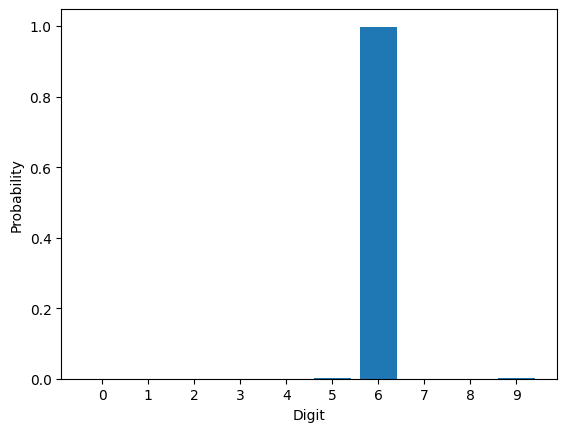


Calculated Bayesian probabilities:
 {6: np.float64(0.998262279631268), 9: np.float64(0.0008293643718945916), 5: np.float64(0.0006686843761647674), 3: np.float64(0.00010651148314385654), 8: np.float64(6.462513075619627e-05), 0: np.float64(2.819396020636445e-05), 4: np.float64(2.494396728655361e-05), 2: np.float64(9.092351657941585e-06), 7: np.float64(3.4673591492501394e-06), 1: np.float64(2.8373684724498996e-06)}

Model's prediction:  6


(np.int64(6),
 array([2.81939602e-05, 2.83736847e-06, 9.09235166e-06, 1.06511483e-04,
        2.49439673e-05, 6.68684376e-04, 9.98262280e-01, 3.46735915e-06,
        6.46251308e-05, 8.29364372e-04]))

In [10]:
%cd -
%cd digit_classifier_test/
wav = [['JACZM24_6_.wav']]
mfcc = generate_mfcc(wav)
nb_score(gmms, mfcc[0][0],verbose="True")

##Ewaluacja kroswalidacyjna

In [11]:
%cd -
%cd train/
models, fin_acc, fin_std = banana_split(train, folds=11, mix=True, verbose=True)

/content/digit-classifier-PL
/content/digit-classifier-PL/train
Fold 1:
 Accuracy: 1.0

Fold 2:
 Accuracy: 1.0

Fold 3:
 Accuracy: 1.0

Fold 4:
 Accuracy: 0.95

Fold 5:
 Accuracy: 1.0

Fold 6:
 Accuracy: 1.0

Fold 7:
 Accuracy: 1.0

Fold 8:
 Accuracy: 1.0

Fold 9:
 Accuracy: 0.95

Fold 10:
 Accuracy: 1.0

Fold 11:
 Accuracy: 1.0

Crossvalidated accuracy: 0.99
 Crossvalidated accuracy standard deviation: 0.02


#Optymalizacja architektury - omówienie

## Aplikacja CMVN
CMVN (cepstral mean and variance normalization) to dosyć prosta operacja zarówno rozumieniowo jak i obliczeniowo, dlatego nie widzę powodu żeby nie dołączyć jej do naszego modelu.

Skuteczność pre-cmvn wynosi:


*   73.50% - eval

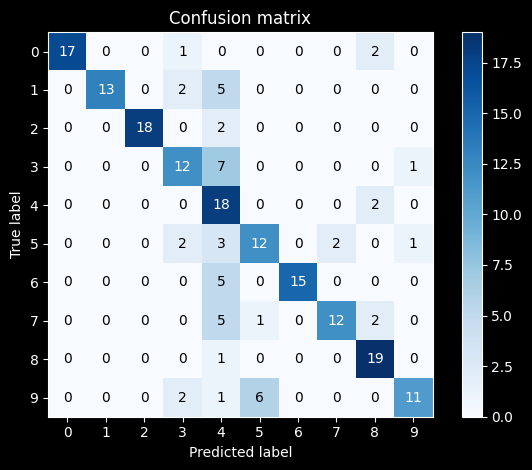

*   62.66% - eval_ia_2024

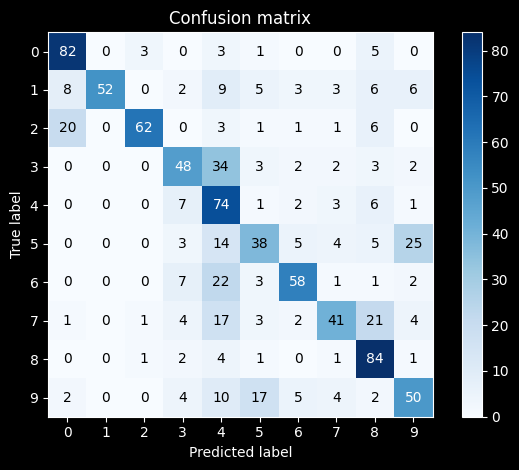

Kroswalidacyjna skuteczność wynosi wówczas 0.92 z odchyleniem standardowym 0.07.

Samo CMN działa na zasadzie dołączenia kondensatora do układu, a dodatkowa normalizacja wariancją jedynie pomaga w zwiększeniu dyskryminatywności cech, nie mówiąc o uodpornianiu na zwiększenie głośności sygnału!!!


Skuteczność post-cmvn wynosi:

* 90.50% - eval

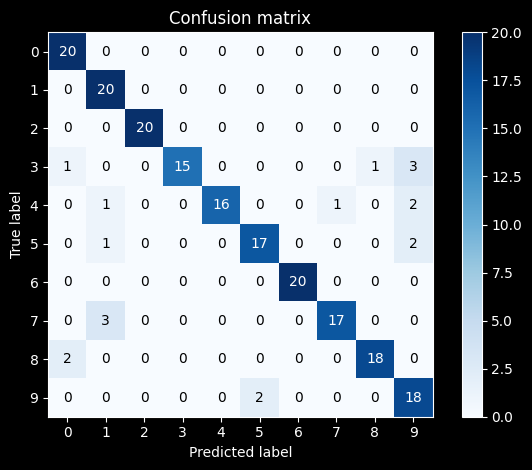

* 71.60% - eval_ia_2024

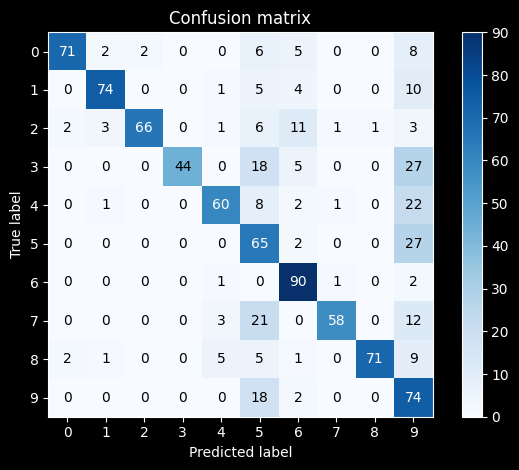

Kroswalidacyjna skuteczność wynosi wówczas 0.96 z odchyleniem standardowym 0.03. Uzyskano więc dwa pozytywne skutki zwiększenia całkowitej średniej skuteczności oraz zmniejszenie odchylenia standardowego pomiędzy poszczególnymi foldami kroswalidacji.



*Przedstawione wyniki są wynikami pojedynczego wywołania kodu. Nie mają przedstawić stacjonarnych wyników, a nakreślić pozytywny wpływ CMVN na skuteczność klasyfikatora*

## Aplikacja Delt MFCC

Delty MFCC ($\Delta, \Delta^2$) to pochodne MFCC. Gdy interesujemy się klasyfikacją zmiennych sygnałów, tempo oraz przyspieszenie zmian mogą pomóc w poprawnej klasyfikacji. Stanowią one jednak kolejne wymiary w naszym problemie uczenia maszynowego. Na potrzeby dydaktyczne, widząc że ekstrakcja cech i trening modelu są akceptowalnie wolne można je zastosować, jednak w momencie w którym zależałoby nam na redukcji wymiarowości lepszym rozwiązaniem stałoby się szukanie sposobów na poprawę skuteczności wśród innych hiperparametrów.

Na potrzeby demonstracji wpływu delt MFCC na skuteczność klasyfikatora przyjmijmy, że skuteczności pre-$\Delta$ są równe skutecznościom post-CMVN

Skuteczność post-$\Delta$ wyniesie:

* 98.00% - eval

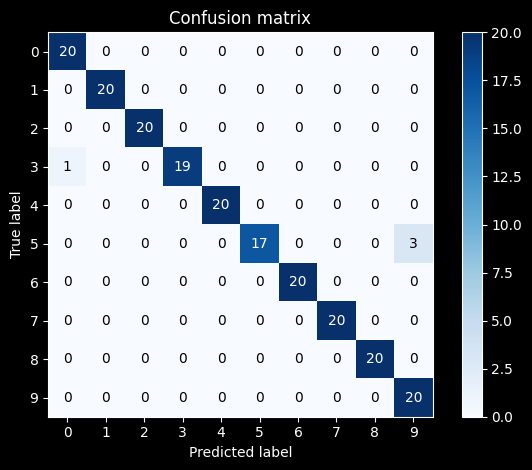

* 84.04% - eval_ia_2024

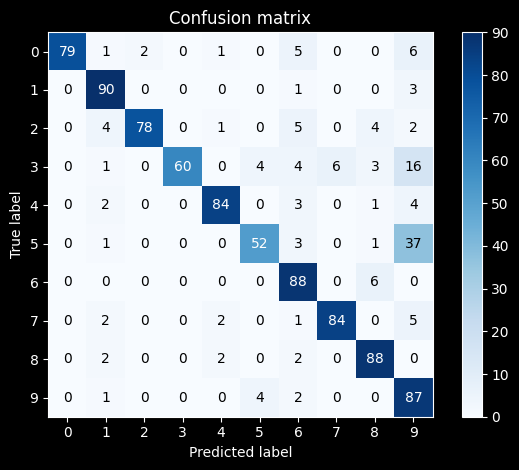


Kroswalidacyjna skuteczność w tym wypadku wzrosła do 1.0 z odchyleniem 0.1. Warto mieć na uwadze, że zaokrągliliśmy wyniki do dwóch miejsc po przecinku, więc mogą stanowić zawyżenie względem wartości rzeczywistych, jednak ponownie zauważono wzrost.

*Ponownie zwracam uwagę na jednostkowość tego sprawdzenia. Mimo wszystko, wprowadzenie delt MFCC niesie za sobą dwie konsekwencje. Zwiększa wymiary (trzykrotnie po wprowadzeniu obu pochodnych), ale co za tym idzie zwiększa dokładność klasyfikacji.*

##Checkpoint - o co chodzi i co dalej?

Udało nam się dojść do punktu, w którym zbiór ewaluacyjny jest rozpoznawany z 98% skutecznością. Kroswalidacja również wykazała praktycznie stuprocentową skuteczność z minimalnym odchyleniem standardowym. Brzmi to relatywnie dobrze porównując obecny model do poziomu 73.50% pre-cmvn. Dlaczego jednak zbiór ewaluacyjny eval_ia_2024 tak bardzo odstaje względem ewaluacyjnego?

Główna różnica występująca pomiędzy tymi dwoma zbiorami, to ich rozmiar. Zbiór eval_ia_2024 posiada prawie 5x więcej nagrań. Widać to w szczególności przy rozpoznawaniu cyfry 5, gdzie przy obu zbiorach jest to najczęściej występujący bład.

Cechą która pozostaje nam do poprawienia jest więc umiejętność generalizacji.

Aplikowawszy wszelkie metaforyczne asy z naszych metaforycznych rękawów (takie jak CMVN oraz delty MFCC), pozostaje jedynie granie tylko metaforycznymi kartami w naszej metaforycznej ręce.

Oznacza to fine-tuning hiperparametrów naszego klasyfikatora. Znając przepływ danych w modelu zauważyć możemy, że to czym możemy się zająć żeby poprawić finalny klasyfikator, to poprawa architektury obiektów GMM, oraz parametryzacji cech za pomocą MFCC.

## Wzrost liczby komponentów GMM

Dosyć oczywistym rozwiązaniem wydaje się wzrost liczby komponentów GMM. Patrząc na to, że najczęściej popełnianym błędem jest nie rozróżnianie cyfry pięć, od dziewięć stwierdzić można, że maksima lokalne w naszej trzydziestowymiarowej hiperprzestrzeni znajdują się relatywnie niedaleko od siebie, porównując to do pozostałych cyfr. Zwiększając liczbę komponentów GMM moglibyśmy zwiększyć dyskryminatywność w ich okolicach, a co za tym idzie, liczyć na spadek liczby błędów.

Przy pojedynczych gaussach skuteczność jest stacjonarna pomiędzy iteracjami poniżej 50% co nie wróży dobrze dla modelu, jednak przy dotychczasowo wykorzystywanym modelu o ośmiu komponentach osiąga poziom post-$\Delta$



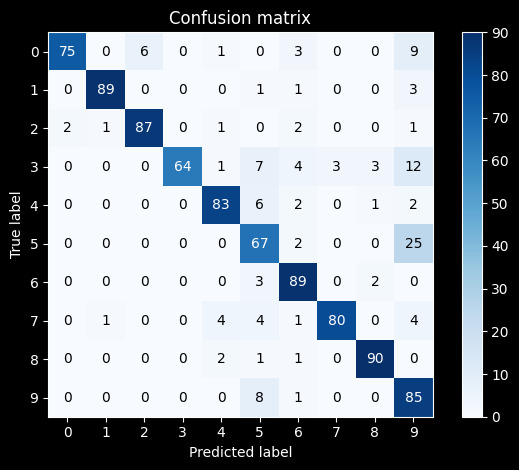

Sprawdźmy co się stanie gdy liczba komponentów zostanie zwiększona.


Zwiększając liczbę komponentów do dziesięciu, udało nam się pomyślnie zredukować błędy. Gdzie w takim razie jest sufit? Ale, ale. Zanim będziemy się cieszyć, przetestujmy tą liczbę komponentów więcej niż jeden raz.

Dla dziesięciu wywołań sprawa potrafi się nieźle skomplikować. Rozkłady okazują się być rzutem monety pomiędzy 78% i 85% klasyfikując wiele cyfr jako 9, co jest odwrotnym do zamierzonego efektu.

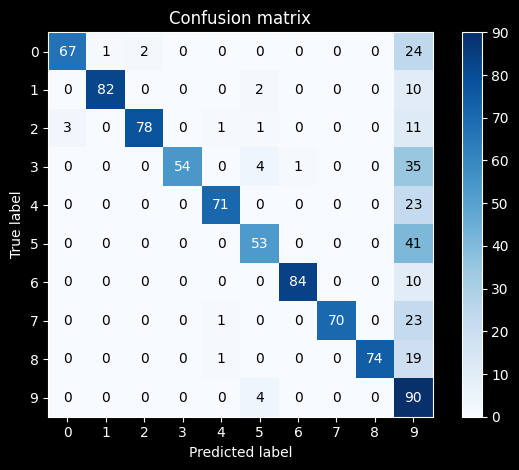

W procesie iteracyjnego wywołania zauważyć można było niestabilność w której sktueczności wahały się pomiędzy wysoką skutecznością > 85% a < 80%.

Widząc rozstrzał wyników pomiędzy iteracjami, lepszym rozwiązaniem będzie pozostać w bardziej stabilnym optimum ośmiu komponentów i poszukać innego rozwiązania dla problemu.

## Pełna, diagonalna, sferyczna i powiązana macierz kowariancji




Kolejną z potencjaknych metod poprawy poprawności predykcji modelu jest zmiana typu macierzy kowariancji przy tworzeniu modelu mikstur Gaussowskich.


**Macierz pełna**


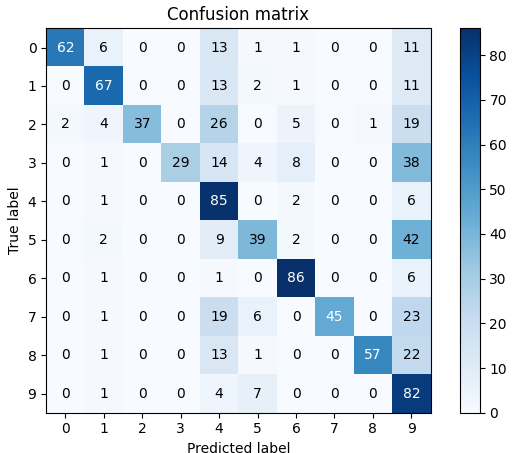

`eval_ia = 64%.` Jak widać na powyższej macierzy wyników wybranie pełnej macierzy kowariancji ma negatywny wpływ na uzyskane wyniki. Ponadto wpływa też bardzo negatywnie na czas wywołania funkcji, gdyż wzrasta on ponad trzykrotnie.

**Macierz sferyczna**

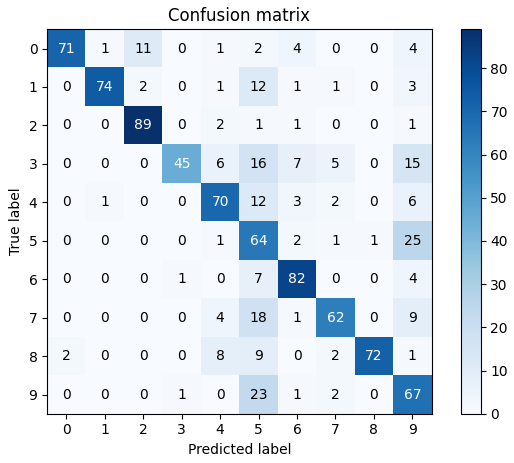

`eval_ia = 74%.` W przypadku macierzy sferycznej nie odnotowano różnicy w prędkości wywoływania funkcji, jednakże wyniki widocznie się pogorszyły. Szczególnie w przypadku zwiększonej liczby błędnych rozpoznań liczby 5.

**Macierz uwiązana**

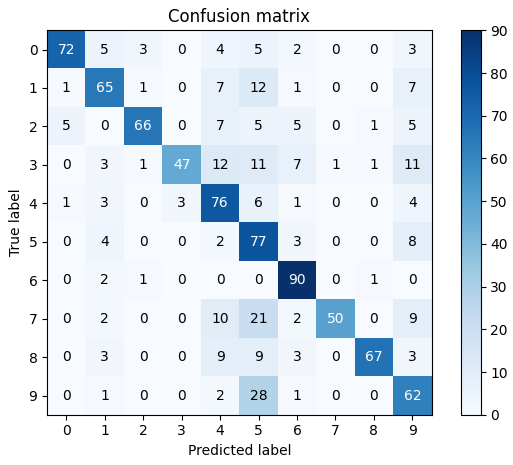

`eval_ia = 71%.` W tym przypadku można zauważyć wzrost liczby podobnych błędów jak w macierzy sferycnej. Jednakże funkcja wywołuje się dwukrotnie dłużej niż w przypadku macierzy diagonalnej.

Biorąc pod uwagę powyższe wyniki, ostateczny model mikstur gaussowskich pozostanie obliczany za pomocą diagonalnych macierzy kowariancji.

## Zmiana tolerancji modelu

Tolerancja modelu to miara zbieżności, która jeśli zostanie przekroczona przez model spowoduje jego zatrzymanie. Zwiększanie tej wartości spowoduje wcześniejsze zatrzymanie treningu modelu. Poprzednie wyniki zostały uzyskane dla domyślnej tolerancji wynoszącej 0.001.

**Zmniejszenie tolerancji**

`eval_ia = 84%.` W przypadku zmniejsznia tolerancji ciężko zauważyć zmiany w dokładności przy 10-krotnym zmniejszeniu. Jednakże trening trwa około 30% dłużej.

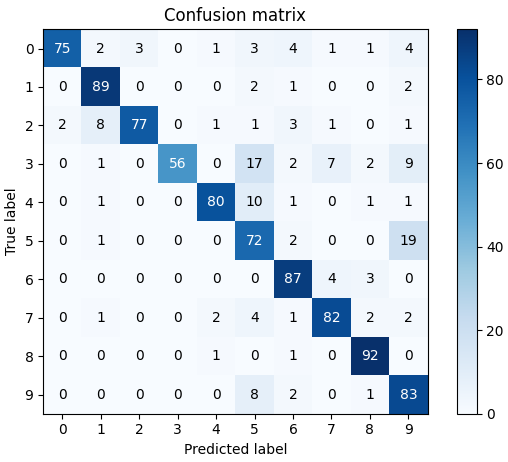

**Zwiększenie tolerancji**

`eval_ia = 82%.` Zwiększenie tolerancji wpłynęło nieznacznie zarówno na czas wykonywania treningu jak i dokłądność przewidywań, jednakże możemy zauważyć niewielki spadek dokładności modelu. Zostajemy więc przy domyślnej tolerancji wynoszącej 0.001

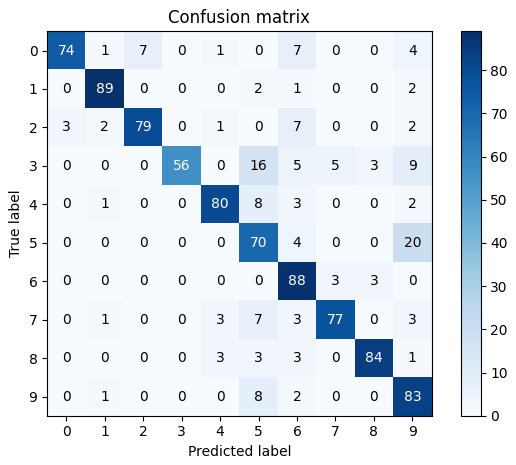

## Tuning parametrów MFCC

**Liczba cech MFCC**

Liczba cech MFCC jest najważniejszym parametrem dla rozpoznawania mowy. Gęstość kolejnych filtrów melowych ma wpływ na istotność kolejnych rozkładów GMM. Dla wyznaczonej wcześniej empirycznie liczby 10 cech uzyskano skuteczność na poziomie 84%. Dalsze wyniki przedstawiają wyniki skuteczności dla wyższych oraz niższych wartości tego parametru.

**Zwiększanie liczby cech**

Zwiększanie liczby cech MFCC nie powodowło większych zmian skuteczności do momentu ok. 15 cech, gdzie zaczęły się błędy wynikające z rozdzielenia istotnych informacji na temat formanów na dwa analizowane w modelu rozkłady.

**Zmniejszanie liczby cech**

Zmniejszanie ilości cech również nie miało większego wpływu na skuteczność modelu w granicach 7 cech. Jednakże warto zauważyć, że dla zmniejszonej do 8 liczby cech kosztem większej liczby błędów fałszywej klasyfikacji cyfry 3 jako 5 zredukowaliśmy liczbę takowych błędów dla cyfry 9. Nie pogarszając skuteczności modelu, która dalej utrzymywała się na poziomie 84%.

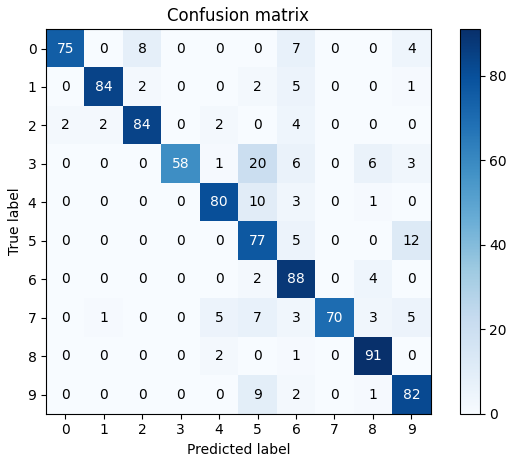

## n_fft

Zmniejszenie n_fft do ninimalnej długości równej długości ramki spowodowało zwiększenie skuteczności modelu o 2 punkty procentowe. W przypadku zwiększania tego parametru nie zaobserwowano większych zmian.

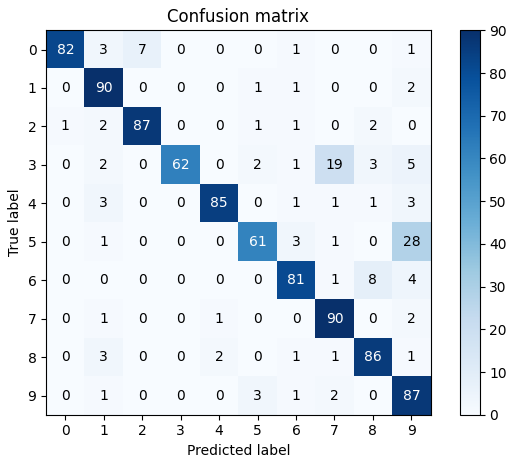

## Liftering

We wcześniejszych przypadkach liftering równał się 10. Użycie lifteringu na poziomie dwukrotności liczby filtrów melowych skutkuje delikatnym poprawieniem skuteczności modelu. Brak liftteringu zaś znacząco pogarsza działanie modelu obniżając jego skuteczność o 10 punktów procentowych. Pozostano przy dwukrotności liczby filtrów.

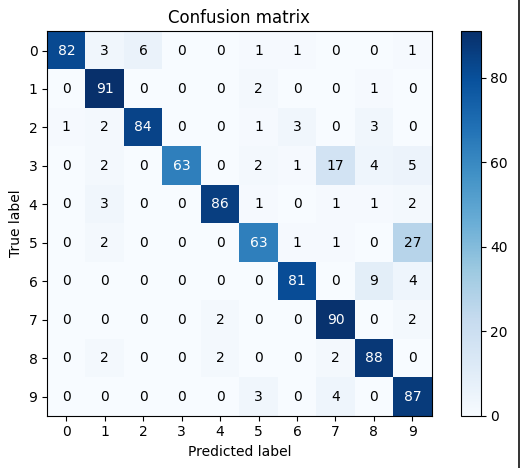

#Podsumowanie

##Optymalizacja

Dla celów dydaktycznych za główny cel przyjęliśmy wzrost skuteczności kosztem czasu i wymiarowości problemu. Dlatego też tak chętnie sięgnęliśmy po deltę MFCC i jej deltę. Wraz ze wzrostem liczby badanych cech MFCC liczba wymiarów wzrasta przez to trzykrotnie. Wpłynęło to jednak w dużym stopniu pozytywnie na skuteczność, przez co można uznać uwzględnienie obu delt za optymalne dla naszego przypadku. Tworząc podobny system w przyszłości, za wystarczające mogłoby się okazać uwzględnienie wyłącznie jednej delty (lub nawet nie branie ich pod uwagę!) chcąc zaoszczędzić na czasie.

\\
Jeśli chodzi o CMVN, to relatywnie niskim kosztem czasowym można było osiągnąć wzrost skuteczności, co potraktować można za sytuację win-win. Przygotowywanie danych do uczenia jest ważnym krokiem w projektach machinelearningowych. Dlatego też za oczywiste uznaliśmy wykorzystanie jej.

\\
Za absolutnie kluczowy, oraz najbardziej oczywisty hiperparametr uznać można liczbę komponentów GMM. Zaczynając od pojedynczych "Gaussów" skuteczność można było znacznie wywindować. Rozkłady tych cech z całą pewnością nie są normalne, więc benefitują ze zwiększonej liczby komponentów. Warto jednak pamiętać o tym, aby nie stracić na umiejętnościach generalizacji dobierając przesadne wartości w tym hiperparametrze.

##Co można zrobić lepiej?

Pierwszą i kluczową rzeczą, którą można byłoby poprawić jest zbiór treningowy. Wychodząc poza ramy czarnej skrzynki którą karmimy nasz model zobaczyć można, że są w nim wyłącznie mężczyźni. Następnie podczas ewaluacji, czy też w waruknach rzeczywistych, model mógłby mieć większy problem przy rozpoznawaniu cyfr dla mówczyń i dzieci. Jeśli nie jest możliwe uzyskanie nagrań głosów kobiecych do treningu, możliwym pozostaje jeszcze ***augmentacja danych***.


 Widać znaczną różnicę pomiędzy skutecznością klasyfikacji na zbiorze eval i eval_ia_2024. Ma to związek z liczebnością zbiorów, ale także znaczna różnica skuteczności niezoptymalizowanego modelu pomiędzy zbiorami ewaluacyjnymi może wskazywać na to, że zbiór treningowy i eval mogą dzielić pewną dozę podobieństwa związanego z warunkami nagrań, czy sprzętem. Nie pojawia się to jednak w przypadku zbioru eval_ia_2024 który oprócz liczności charakteryzuje się różnorodnością stanowisk na których nagrania te powstały. Dlatego też, podczas przyszłego tworzenia zbioru treningowego, można dodać nagrania odpowiednio zniekształcone, na przykład poprzez pitch shift, lub dodanie pewnego rodzaju szumu. Owszem, normalizacja cepstralna średnią pozbywa się składowej stałej z wierszy macierzy MFCC, jednak nie wszystkie zniekształcenia muszą być stacjonarne. Dodatkowo, zbiór treningowy można byłoby po prostu zwiększyć. Wydaje się to być rozwiązaniem najbardziej trywialnym, a czasami takie rozwiązania są najbardziej skuteczne. W momentach w których nas jednak nie stać na taki manewr warto pamiętać o augmentacji danych.

 Dodatkowo, w celach finalizacyjnych, analogicznie GMM, nasz gotowy klasyfikator można byłoby "sklasyfikować" *(wordplay)* - doprowadzić do postaci obiektu klasy. Mogłoby to ułatwić przyszłą pracę nad jego rozwojem, czy pozwolić na przepłw różnych zbiorów treningowych i łatwą zmianę hiperparametrów.

##Posłowie
Całościowo projekt, jako narzędzie nauki pozwolił poznać podstawy zasad działania modeli uczenia maszynowego oraz rozpoznawania mowy. Pomimo nieidealnych wyników, zarówno na przestrzeni stawianych zadań w kolejnych notatnikach, jak i wynikach w skuteczności uważam, że zadanie to zostało wykoane przez nas w stopniu conajmniej zadowalającym. Projekt ten mógłby być jeszcze doskonalony a wyniki dodatkowo podkręcone, ale niestety nie pozwolił na to w stu procentach czas i myśli. Dziękujemy za wszelkie rady na przestrzeni tych zajęć.

\\
<center><font size="3">Koniec projektu pierwszego.</font></center>
